## Аналитика по сервису доставки продуктов

Компания-сервис по доставке продуктов на дом, сервис доступен на iOS, Android. Данные из AppMetrica за период с 1 января по 31 марта 2020 — только по пользователям, зарегистрированным позднее 1 января 2020.

**ОПИСАНИЕ ДАННЫХ** 

→ date — дата совершения события

→ event — событие

<br>app_install — установка приложения
<br>app_start —  открыть приложения
<br>register — зарегистрироваться 
<br>search — перейти на страницу поиска товаров (каталог)
<br>open_item — открыть товар
<br>choose_item — отправить товар в корзину
<br>tap_basket — перейти в корзину
<br>purchase — подтверждение покупки

→ gender — пол пользователя

→ os_name —  платформа пользователя

→ city —  город пользователя

→ device_id — идентификатор устройства пользователя

→ utm_source — канал, с которого пришел пользователь

<br>yandex-direct — Яндекс.Директ
<br>google_ads — реклама в Google
<br>vk_ads — реклама в ВК
<br>instagram_ads — реклама в Инстаграм*
<br>facebook_ads — реклама в Фейсбук*
<br>referral — акция «приведи друга»
<br>Если стоит - (прочерк), то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  

→ purchase_sum —  стоимость покупки (при совершении события ‘purchase’)

**Attention**
<br>В выгрузке только уникальные действия пользователей за каждый день.
<br>Можно миновать стадию установки приложения, если оно было установлено ранее.
<br>Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку.

In [1]:
# подгрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


## Анализ воронки

In [2]:
# строим воронки по зарегистрированным/незарегистрированным пользователям
registered = df[df['event'] == 'register']
funnel_mapping = pd.DataFrame({
    'event': ['app_install', 'app_start', 'search', 'choose_item', 'tap_basket', 'register', 'purchase'],})
funnel_mapping = funnel_mapping.reset_index().set_index('event')

df = pd.merge(df, registered[['device_id','date']], on='device_id', how='left')
df = pd.merge(df, funnel_mapping, on='event', how='left')
df.rename(columns={'date_x': 'date','date_y': 'register_date', 'index':'funnel_step'}, inplace=True)
df['registered_user'] = df['register_date'] < df['date'] 
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,register_date,funnel_step,registered_user
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-07,1,False
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,1,False
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01,1,False
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,1,False
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,NaN,1,False


In [4]:
# воронка по зарегистрированным пользователям
events = ['app_start', 'search', 'choose_item', 'tap_basket', 'purchase']
counter = []
for i in events:
    counter.append(df[(df['registered_user'] == True) & (df['event'] == i)]['device_id'].nunique())
    
ddr_reg = pd.DataFrame({'event':events,'count':counter})
ddr_reg['delta'] = ddr_reg['count'] - ddr_reg['count'].shift(1)
ddr_reg

,event,count,delta
0,app_start,40991,NaN
1,search,40482,-509.0
2,choose_item,37926,-2556.0
3,tap_basket,34517,-3409.0
4,purchase,24880,-9637.0


Зарегистрированные пользователи сильно отваливаются на этапе перехода от корзины к покупке

In [5]:
# воронка по незарегистрированным пользователям
events = ['app_start', 'search', 'choose_item', 'tap_basket', 'register', 'purchase']
counter = []
for i in events:
    counter.append(df[(df['registered_user'] == False) & (df['event'] == i)]['device_id'].nunique())
    
ddr_noreg = pd.DataFrame({'event':events,'count':counter})
ddr_noreg['delta'] = ddr_noreg['count'] - ddr_noreg['count'].shift(1)
ddr_noreg

,event,count,delta
0,app_start,190884,NaN
1,search,184488,-6396.0
2,choose_item,155691,-28797.0
3,tap_basket,125414,-30277.0
4,register,78310,-47104.0
5,purchase,67753,-10557.0


Незарегистрированные пользователи сильно отваливаются на этапе перехода к регистрации

In [6]:
# конверсия в первую покупку по источникам трафика - рефералы показывают лучшую конверсию
sources = df['utm_source'].unique()
installs = []
purchased = []

for i in sources:
    installs.append(df[(df['registered_user'] == False) & (df['event'] == 'app_install') & (df['utm_source'] == i)]['device_id'].nunique())
    purchased.append(df[(df['registered_user'] == False) & (df['event'] == 'purchase') & (df['utm_source'] == i)]['device_id'].nunique())
    
ddr = pd.DataFrame({'sources':sources,'installs':installs,'purchases':purchased})
ddr['conversion %'] = round(ddr['purchases']/ddr['installs']*100,1)
ddr.sort_values('conversion %', ascending=False)

,sources,installs,purchases,conversion %
2,referal,9282,5503,59.3
3,facebook_ads,13916,7506,53.9
1,vk_ads,23189,10919,47.1
5,instagram_ads,20096,9394,46.7
0,-,32460,14073,43.4
4,google_ads,26286,9777,37.2
6,yandex-direct,29368,10581,36.0


In [7]:
# медианный чек первой покупки по источникам трафика
sources = df['utm_source'].unique()
check = []

for i in sources:
    check.append(df[(df['registered_user'] == False) & (df['event'] == 'purchase') & (df['utm_source'] == i)]['purchase_sum'].median())
    
ddr = pd.DataFrame({'sources':sources,'median check':check})
ddr.sort_values('median check', ascending=False)

,sources,median check
0,-,399.0
2,referal,398.0
5,instagram_ads,393.0
1,vk_ads,392.5
6,yandex-direct,392.5
4,google_ads,390.5
3,facebook_ads,388.5


## ROMI

**Расчеты эффективности маркетинга. Затраты по каналам:**
<br>VK Ads = 9 553 531 руб
<br>Рефералы = 200 * кол-во привлеченных покупателей руб
<br>Instagram Ads = 8 561 626 руб
<br>Facebook Ads = 8 590 498 руб
<br>Yandex Direct = 10 491 707 руб
<br>Google Ads = 10 534 878 руб

In [8]:
# считаем кол-во привлеченных покупателей, общую сумму покупок и return on marketing investment
sources = df['utm_source'].unique()
purchased = []
p_sum = []

for i in sources:
    purchased.append(df[(df['registered_user'] == False) & (df['event'] == 'purchase') & (df['utm_source'] == i)]['device_id'].nunique())
    p_sum.append(df[(df['event'] == 'purchase') & (df['utm_source'] == i)]['purchase_sum'].sum())
    
ddr = pd.DataFrame({'sources':sources,'buyers':purchased,'purchase_sum':p_sum})

ddr['marketing_cost'] = [0,9553531,200*ddr['buyers'].iloc[2],8590498,10534878,8561626,10491707]
ddr = ddr[1:]

In [9]:
# реферальный канал генерирует 8 руб выручки с 1 руб маркетинговых затрат
ddr['ROMI'] = round((ddr['purchase_sum']-ddr['marketing_cost'])/ddr['marketing_cost']*100,1)
ddr.sort_values('ROMI',ascending=False)

,sources,buyers,purchase_sum,marketing_cost,ROMI
2,referal,5503,8837044.5,1100600,702.9
1,vk_ads,10919,16389652.5,9553531,71.6
5,instagram_ads,9394,14546969.0,8561626,69.9
3,facebook_ads,7506,12249901.0,8590498,42.6
6,yandex-direct,10581,13915368.0,10491707,32.6
4,google_ads,9777,12868276.0,10534878,22.1


## Когортный анализ

In [10]:
# RETENTION
# определяем недельную когорту по дате первого запуска приложения, название когорты устанавливаем по первому понедельнику недели
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df_c = df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id', keep='first')
df_c['cohort'] = df_c['date'] - df_c['date'].dt.weekday * np.timedelta64(1, 'D')

# строим когортный анализ по запускам приложения
df_cohorts = pd.merge(df[df['event'] == 'app_start'], df_c[['device_id','cohort']], how='left', on='device_id')
df_cohorts['n_week'] = df_cohorts['date']-df_cohorts['cohort']
df_cohorts['n_week'] = df_cohorts['n_week'].apply(lambda x: x.days // 7)

cohorts = df_cohorts['cohort'].dt.strftime('%Y-%m-%d').unique()

data = {'cohort':cohorts}
for i in range(0,df_cohorts['n_week'].max()+1):
    label = 'week ' + str(i)
    values = []
    for c in cohorts:
        value = df_cohorts[(df_cohorts['cohort'] == c) & (df_cohorts['n_week'] == i)]['device_id'].nunique()
        if value == 0:
            values.append('')
        else:
            values.append(value)
    data[label] = values
    
output = pd.DataFrame(data)
output

,cohort,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13
0,2019-12-30,15705,7551,6792,6338,5794,5295,5452,5387,4853,4983,4541,4355,4498,2227
1,2020-01-06,31315,8228,6040,4958,4222,4540,4553,3507,4136,3246,2944,3047,1143,
2,2020-01-13,30505,5067,3861,3122,3610,3175,2303,2894,1983,1818,1923,661,,
3,2020-01-20,12319,1863,1443,1706,1543,1079,1388,918,791,873,278,,,
4,2020-01-27,13119,2037,1971,1669,1227,1397,1003,875,909,318,,,,
5,2020-02-03,10967,1991,1599,1126,1266,933,804,839,273,,,,,
6,2020-02-10,16015,2559,1487,2083,1227,1019,1031,350,,,,,,
7,2020-02-17,11974,1511,1606,995,845,884,281,,,,,,,
8,2020-02-24,5172,933,625,499,509,173,,,,,,,,
9,2020-03-02,15001,1044,780,796,237,,,,,,,,,


In [11]:
# строим показатель retention (%) по когортам
output_percentage = output.copy()
for row in range(len(output_percentage)):
    for column in output_percentage.iloc[:,2:].columns:
        try:
            output_percentage.at[row,column] = round(output_percentage.loc[row,column]/output_percentage.loc[row,'week 0']*100,0)
        except:
            output_percentage.at[row,column] = ''

for row in range(len(output_percentage)):
    output_percentage.at[row,'week 0'] = 100
    
output_percentage

,cohort,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13
0,2019-12-30,100,48,43,40,37,34,35,34,31,32,29,28,29,14
1,2020-01-06,100,26,19,16,13,14,15,11,13,10,9,10,4,
2,2020-01-13,100,17,13,10,12,10,8,9,7,6,6,2,,
3,2020-01-20,100,15,12,14,13,9,11,7,6,7,2,,,
4,2020-01-27,100,16,15,13,9,11,8,7,7,2,,,,
5,2020-02-03,100,18,15,10,12,9,7,8,2,,,,,
6,2020-02-10,100,16,9,13,8,6,6,2,,,,,,
7,2020-02-17,100,13,13,8,7,7,2,,,,,,,
8,2020-02-24,100,18,12,10,10,3,,,,,,,,
9,2020-03-02,100,7,5,5,2,,,,,,,,,


In [12]:
# REVENUE
# определяем недельную когорту по дате первой покупки, название когорты устанавливаем по первому понедельнику недели
df_c = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id', keep='first')
df_c['cohort'] = df_c['date'] - df_c['date'].dt.weekday * np.timedelta64(1, 'D')

df_cohorts = pd.merge(df[df['event'] == 'purchase'], df_c[['device_id','cohort']], how='left', on='device_id')
df_cohorts['n_week'] = df_cohorts['date']-df_cohorts['cohort']
df_cohorts['n_week'] = df_cohorts['n_week'].apply(lambda x: x.days // 7)

# строим когортный анализ по выручке и тотаты по когортам
cohorts = df_cohorts['cohort'].dt.strftime('%Y-%m-%d').unique()

data = {'cohort':cohorts}
for i in range(0,df_cohorts['n_week'].max()+1):
    label = 'week ' + str(i)
    values = []
    for c in cohorts:
        value = df_cohorts[(df_cohorts['cohort'] == c) & (df_cohorts['n_week'] == i)]['purchase_sum'].sum()
        if value == 0:
            values.append(np.nan)
        else:
            values.append(value)
    data[label] = values
    
output = pd.DataFrame(data)
output['total'] = [output.loc[i,'week 0':'week 13'].sum() for i in range(len(output))]
output.fillna('',inplace=True)
output

,cohort,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,total
0,2019-12-30,3558860.5,1.25528e+06,992076,883233,805830,702143,646392,634484,584806,583159,490457,509860,543310,130286,12320177.5
1,2020-01-06,8919234.5,1.77148e+06,1.41195e+06,1.24066e+06,939792,1.00656e+06,931626,856064,728917,701898,526804,638230,114633,,19787838.0
2,2020-01-13,10589801.0,1.62378e+06,1.20772e+06,889391,818894,719284,737876,613872,607749,412128,508907,123048,,,18852452.0
3,2020-01-20,4907695.5,747083,521446,477168,514961,466404,374464,347886,297802,311080,52058,,,,9018049.5
4,2020-01-27,4346041.5,611272,438043,461528,398260,316876,270943,247240,271542,70888,,,,,7432634.0
5,2020-02-03,3855562.5,546723,506553,382793,289561,302178,185490,209118,27258,,,,,,6305237.0
6,2020-02-10,4515630.5,611120,455674,354512,272616,228958,271054,56749.5,,,,,,,6766314.0
7,2020-02-17,3576614.0,524632,442594,309370,241054,257278,47294.5,,,,,,,,5398837.5
8,2020-02-24,2027450.0,409674,244445,152695,195626,37743.5,,,,,,,,,3067633.5
9,2020-03-02,2843039.5,352062,179273,217237,38161,,,,,,,,,,3629773.0


In [13]:
# MEDIAN CHECK
# определяем недельную когорту по дате первой покупки, название когорты устанавливаем по первому понедельнику недели
df_c = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id', keep='first')
df_c['cohort'] = df_c['date'] - df_c['date'].dt.weekday * np.timedelta64(1, 'D')

df_cohorts = pd.merge(df[df['event'] == 'purchase'], df_c[['device_id','cohort']], how='left', on='device_id')
df_cohorts['n_week'] = df_cohorts['date']-df_cohorts['cohort']
df_cohorts['n_week'] = df_cohorts['n_week'].apply(lambda x: x.days // 7)

# строим когортный анализ по медианному чеку
cohorts = df_cohorts['cohort'].dt.strftime('%Y-%m-%d').unique()

data = {'cohort':cohorts}
for i in range(0,df_cohorts['n_week'].max()+1):
    label = 'week ' + str(i)
    values = []
    for c in cohorts:
        value = df_cohorts[(df_cohorts['cohort'] == c) & (df_cohorts['n_week'] == i)]['purchase_sum'].median()
        if pd.isna(value):
            values.append('')
        else:
            values.append(value)
    data[label] = values
    
output = pd.DataFrame(data)
output

,cohort,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13
0,2019-12-30,395.00,390.5,391.5,369.5,392,394.75,382,375.5,399.5,385,402.5,405.5,400.5,380.75
1,2020-01-06,396.00,396,393.5,388.25,402.5,411,371,420.25,385.5,385.5,377.5,410,411.25,
2,2020-01-13,389.50,392,390,398.5,391,385.25,396.5,400.75,400.5,397,411,423.5,,
3,2020-01-20,397.50,404,366.5,377,384.5,395.5,397.5,406.25,388,375,452.75,,,
4,2020-01-27,394.75,389,386.5,397,389.75,385.5,393.5,392,401,353,,,,
5,2020-02-03,398.00,410.25,404.25,381.25,419,409,387,357,327.25,,,,,
6,2020-02-10,397.00,380.25,396.5,403,431.25,421,382,364.5,,,,,,
7,2020-02-17,392.00,392,388.25,391.5,421.5,407,418.25,,,,,,,
8,2020-02-24,383.00,415.5,415.5,375.5,409.5,381,,,,,,,,
9,2020-03-02,393.50,403.5,409,399.5,430,,,,,,,,,


In [14]:
# строим по-недельный анализ медианного чека по источникам трафика с 30.12.2019 по 30.03.2020
df_c = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id', keep='first')
df_c['cohort'] = df_c['date'] - df_c['date'].dt.weekday * np.timedelta64(1, 'D')

df_cohorts = pd.merge(df[df['event'] == 'purchase'], df_c[['device_id','cohort']], how='left', on='device_id')
df_cohorts['n_week'] = df_cohorts['date']-df_cohorts['cohort']
df_cohorts['n_week'] = df_cohorts['n_week'].apply(lambda x: x.days // 7)

cohorts = df_cohorts['cohort'].dt.strftime('%Y-%m-%d').unique()

data = {'source':df['utm_source'].unique()}
for i in range(0,df_cohorts['n_week'].max()+1):
    label = 'week ' + str(i)
    values = []
    for c in df['utm_source'].unique():
        value = round(df_cohorts[(df_cohorts['utm_source'] == c) & (df_cohorts['n_week'] == i)]['purchase_sum'].median(),0)
        if pd.isna(value):
            values.append('')
        else:
            values.append(value)
    data[label] = values
    
output = pd.DataFrame(data)
output

,source,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13
0,-,398.0,400.0,398.0,398.0,389.0,390.0,396.0,393.0,402.0,380.0,400.0,416.0,408.0,402.0
1,vk_ads,393.0,398.0,382.0,382.0,410.0,405.0,382.0,407.0,390.0,385.0,376.0,422.0,379.0,362.0
2,referal,394.0,376.0,386.0,374.0,399.0,396.0,362.0,370.0,365.0,365.0,403.0,379.0,401.0,390.0
3,facebook_ads,388.0,396.0,406.0,407.0,394.0,392.0,380.0,418.0,402.0,400.0,402.0,432.0,414.0,370.0
4,google_ads,392.0,385.0,379.0,375.0,410.0,400.0,388.0,377.0,377.0,399.0,403.0,404.0,416.0,300.0
5,instagram_ads,396.0,414.0,390.0,397.0,410.0,398.0,392.0,392.0,378.0,399.0,402.0,395.0,409.0,356.0
6,yandex-direct,392.0,390.0,384.0,388.0,396.0,415.0,409.0,395.0,395.0,406.0,398.0,413.0,372.0,384.0


## Визуализация результатов

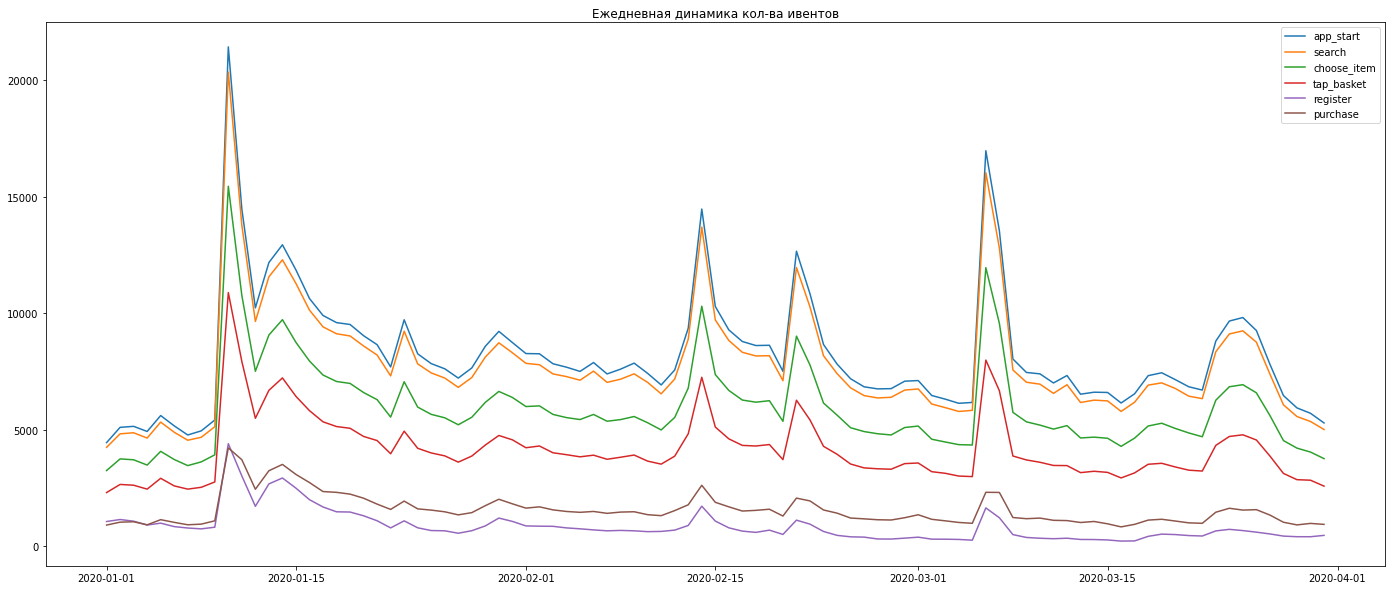

In [15]:
# ежедневная динамика кол-ва ивентов
fig, ax = plt.subplots(figsize=(24,10))

for i in events:
    event_group = df[df['event'] == i].groupby('date')['event'].count()
    ax.plot(df['date'].unique(), event_group)

ax.set_title('Ежедневная динамика кол-ва ивентов')
ax.legend(events)    
plt.show()

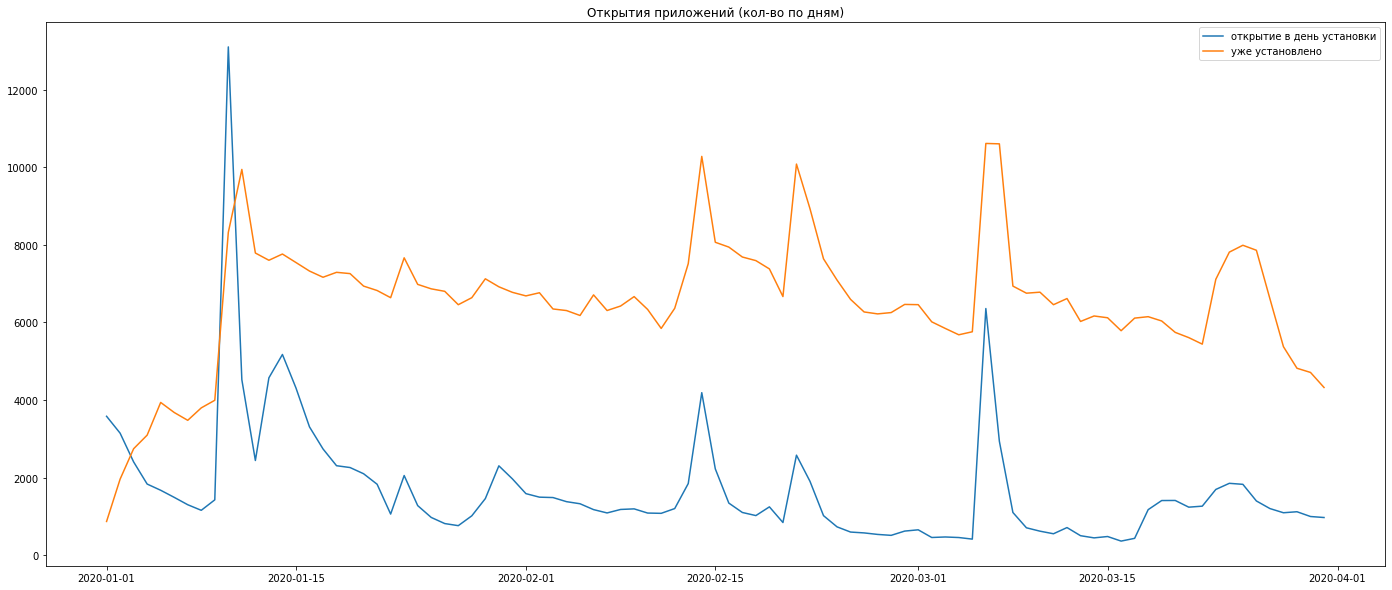

In [16]:
# открытия приложения по группам пользователей - те которые открыли в день установки, и те у которых приложение уже было установлено
app_starts = df[df['event'] == 'app_start']
app_installs = df[df['event'] == 'app_install']

asd = pd.merge(app_starts, app_installs[['device_id', 'date']], how='left', on='device_id')
asd['status'] = ['открытие в день установки' if asd['date_x'].iloc[i]==asd['date_y'].iloc[i] else 'уже установлено' for i in range(len(asd))]

fig, ax = plt.subplots(figsize=(24,10))

for i in asd['status'].unique():
    status_group = asd[asd['status'] == i].groupby('date_x')['event'].count()
    ax.plot(asd['date_x'].unique(), status_group)

ax.set_title('Открытия приложений (кол-во по дням)')
ax.legend(asd['status'].unique())    
plt.show()

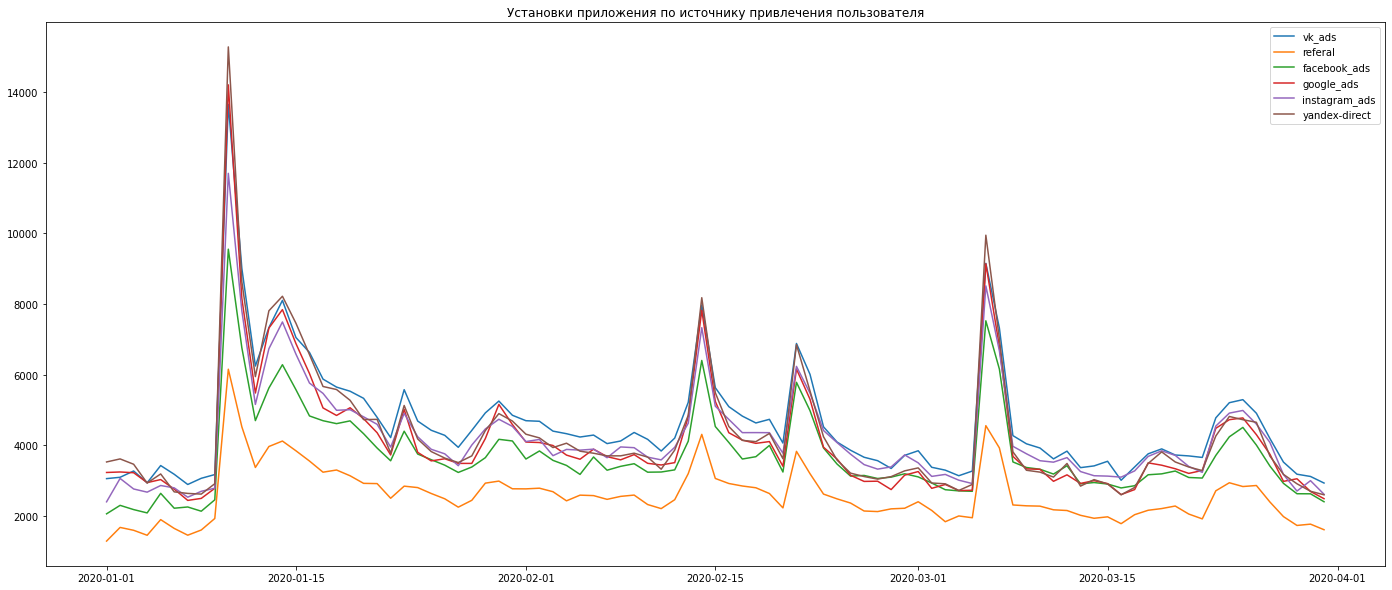

In [17]:
# визуализация установок приложения по источнику привлечения пользователя
fig, ax = plt.subplots(figsize=(24,10))

for i in np.delete(df['utm_source'].unique(), np.argwhere(df['utm_source'].unique()=='-')):
    source_group = df[df['utm_source'] == i].groupby('date')['event'].count()
    ax.plot(df['date'].unique(), source_group)

ax.set_title('Установки приложения по источнику привлечения пользователя')
ax.legend(np.delete(df['utm_source'].unique(), np.argwhere(df['utm_source'].unique()=='-')))    
plt.show()

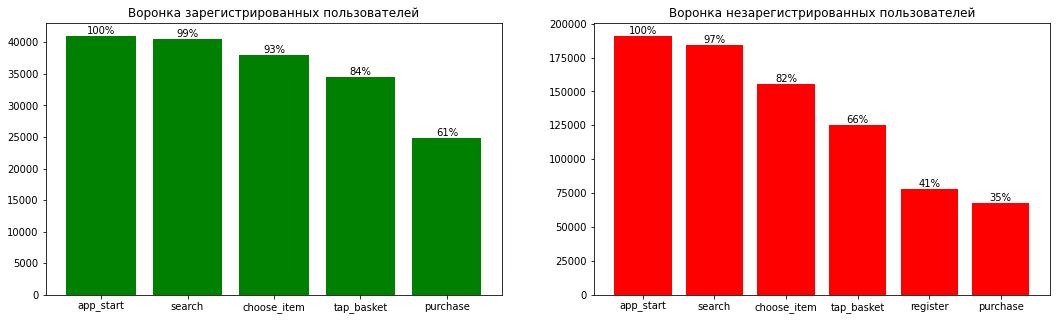

In [18]:
# визуализация воронки по зарегистрированным/незарегистрированным пользователям
ddr_reg['remainder %'] = [round(ddr_reg['count'].iloc[i]/ddr_reg['count'].iloc[0]*100,0) for i in range(len(ddr_reg))]
ddr_noreg['remainder %'] = [round(ddr_noreg['count'].iloc[i]/ddr_noreg['count'].iloc[0]*100,0) for i in range(len(ddr_noreg))]

fig, ax = plt.subplots(1, 2, figsize=(18,5))

ax[0].bar(ddr_reg['event'], ddr_reg['count'], color='green')
ax[1].bar(ddr_noreg['event'], ddr_noreg['count'], color='red')
ax[0].set_title('Воронка зарегистрированных пользователей')
ax[1].set_title('Воронка незарегистрированных пользователей')
for bar, label in zip(ax[0].patches, np.array(ddr_reg['remainder %'])):
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(int(label))+'%', ha="center", va="bottom")
for bar, label in zip(ax[1].patches, np.array(ddr_noreg['remainder %'])):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(int(label))+'%', ha="center", va="bottom")

plt.show()